In [3]:
from datasets import load_dataset_builder
from datasets import load_dataset
from string import punctuation
import numpy as np
from sklearn import preprocessing
import random

N = 25000

n = 3500

d = 50
random.seed = 42

# The dataset

In [2]:
ds_builder = load_dataset_builder("imdb")

In [3]:
ds_builder.info.description

'Large Movie Review Dataset.\nThis is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.'

In [4]:
dataset = load_dataset("imdb")
dataset

Reusing dataset imdb (/home/peuleu/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

The IMDB dataset contain 3 splits:<br>
    -The train dataset that contain 25000 elements<br>
    -The test dataset that contain 25000 elements<br>
    -The unsupervised dataset that contain 50000 element

# Naive Bayes classifier

Preprocessing

In [5]:
def transformStr(Str):
    return Str.translate(str.maketrans('', '', punctuation)).lower()

def transformList(lst):
    
    lst[0] = transformStr(lst[0])
    
    return lst

def transformRow(row):
    if 'text' in row :
        row['text'] = transformList(row['text'])
            
    return row

In [6]:
dataset['train'].set_transform(transformRow)
dataset['test'].set_transform(transformRow)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Naive bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

In [9]:
MNB = MultinomialNB()

In [10]:
X_train_text =  [dataset['train'][i]['text'] for i in range(N)]
X_test_text = [dataset['test'][i]['text'] for i in range(N)]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

words = dict()

for row in X_train_text :
    for e in row.split(' ') :
        if not e in words:
            words[e] = 1
        else :
            words[e] += 1
            
words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}

words = dict(zip(list(words.keys())[d:n+d], list(words.values())[d:n+d]))

le = dict(zip(words, range(n)))

In [11]:
def createTab(dataset):
    rtn = np.zeros((N, n))
    
    for index in range(N):
        for word in dataset[index].split(' ') :
            if word in words:
                rtn[index][le[word]] += 1
                
    return rtn

X_train = createTab(X_train_text)
X_test = createTab(X_test_text)

In [12]:
"""
c = list(zip(X_train, y_train))
random.shuffle(c)
X_train, y_train = zip(*c)"""

'\nc = list(zip(X_train, y_train))\nrandom.shuffle(c)\nX_train, y_train = zip(*c)'

In [13]:
len(y_train)

25000

In [14]:
y_pred = MNB.fit(X_train, y_train).predict(X_test)

In [15]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 25000 points : 3857


In [16]:
def printResults(l):
    rtn = dict()
    for e in l:
        if not e in rtn:
            rtn[e] = 1
        else :
            rtn[e] += 1
            
    print(rtn)
    
print(printResults(y_pred))
print(printResults(y_test))

{0: 12845, 1: 12155}
None
{0: 12500, 1: 12500}
None


In [17]:
le#17233

{'when': 0,
 'more': 1,
 'very': 2,
 'even': 3,
 'she': 4,
 'my': 5,
 'no': 6,
 'up': 7,
 'would': 8,
 'which': 9,
 'only': 10,
 'time': 11,
 'really': 12,
 'story': 13,
 'their': 14,
 'were': 15,
 'had': 16,
 'see': 17,
 'can': 18,
 'me': 19,
 'than': 20,
 'we': 21,
 'much': 22,
 'well': 23,
 'been': 24,
 'get': 25,
 'will': 26,
 'into': 27,
 'also': 28,
 'because': 29,
 'other': 30,
 'do': 31,
 'people': 32,
 'bad': 33,
 'great': 34,
 'first': 35,
 'how': 36,
 'most': 37,
 'him': 38,
 'dont': 39,
 'made': 40,
 'then': 41,
 'movies': 42,
 'make': 43,
 'films': 44,
 'could': 45,
 'way': 46,
 'them': 47,
 'any': 48,
 'too': 49,
 'after': 50,
 'characters': 51,
 'think': 52,
 'watch': 53,
 'two': 54,
 'many': 55,
 'being': 56,
 'seen': 57,
 'character': 58,
 'never': 59,
 'little': 60,
 'acting': 61,
 'where': 62,
 'plot': 63,
 'best': 64,
 'love': 65,
 'did': 66,
 'know': 67,
 'life': 68,
 'show': 69,
 'does': 70,
 'ever': 71,
 'your': 72,
 'still': 73,
 'better': 74,
 'over': 75,
 'off

<AxesSubplot:>

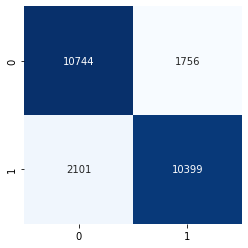

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [19]:
print(qdsfqsdvcwdcsdcqsvw)

NameError: name 'qdsfqsdvcwdcsdcqsvw' is not defined

In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 

import re

nltk.download('punkt')

def stemmer(text):
    re_word = re.compile(r"^\w+$")
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for word in word_tokenize(text.lower()) if re_word.match(word)]
    rtn = " ".join(stemmed)
    #print(text)
    return rtn

def transformList2(lst):
    lst[0] = stemmer(lst[0])
    
    return lst

def transformRow2(row):
    if 'text' in row :
        row['text'] = transformList2(row['text'])
            def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
    return row

dataset2 = load_dataset("imdb")
dataset2['train'].set_transform(transformRow2)
dataset2['test'].set_transform(transformRow2)

In [ ]:
dataset2['train'][1]['text']

In [ ]:
X_train_text2 =  [dataset2['train'][i]['text'] for i in range(N)]
X_test_text2 = [dataset2['test'][i]['text'] for i in range(N)]

y_train2 = dataset2['train']['label']
y_test2 = dataset2['test']['label']

words2 = dict()


for row in X_train_text :

    for e in row.split(' ') :
        if not e in words2:
            words2[e] = 1
        else :
            words2[e] += 1
            
words2 = {k: v for k, v in sorted(words2.items(), key=lambda item: item[1], reverse=True)}

words2 = dict(zip(list(words2.keys())[:n], list(words2.values())[:n]))

le2 = dict(zip(words2, range(n)))

def createTab(dataset):
    rtn = np.zeros((N, n))
    
    for index in range(N):
        for word in dataset[index].split(' ') :
            if word in words2:
                rtn[index][le2[word]] += 1
                
    return rtn

In [ ]:
dataset2['train'][1]['text']

In [ ]:
X_train2 = createTab(X_train_text2)
X_test2 = createTab(X_test_text2)

In [ ]:
y_pred2 = MNB.fit(X_train2, y_train2).predict(X_test2)

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test2.shape[0], (y_test2 != y_pred2).sum()))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test2, y_pred2)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
dataset2['train'][0]['text']

In [63]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


stop = set(stopwords.words())
stop.add("br")

import re

nltk.download('punkt')
re_word = re.compile(r"^\w+$")


def stemmer(text):
    text = " ".join([word for word in word_tokenize(text) if not word in stop])
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for word in word_tokenize(text.lower()) if re_word.match(word) and word]
    rtn = " ".join(stemmed)
    #print(text)
    return rtn

def preprocess_function(a):
    a["text"] = list(map(stemmer, a['text']))
    return a

[nltk_data] Downloading package stopwords to /home/peuleu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/peuleu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:


dataset = load_dataset("imdb")
dataset = dataset.map(preprocess_function, batched=True)

Reusing dataset imdb (/home/peuleu/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [65]:
X_train_text =  dataset['train']['text']
X_test_text = dataset['test']['text']
y_train = dataset['train']['label']
y_test = dataset['test']['label']

n = 3500

d = 

words = dict()

for row in X_train_text :
    for e in row.split(' ') :
        if not e in words:
            words[e] = 1
        else :
            words[e] += 1
            
words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}

words = dict(zip(list(words.keys())[d:n+d], list(words.values())[d:n+d]))

le = dict(zip(words, range(n)))

In [66]:
def createTab(dataset):
    rtn = np.zeros((N, n))
    
    for index in range(N):
        for word in dataset[index].split(' ') :
            if word in words:
                rtn[index][le[word]] += 1
                
    return rtn

X_train = createTab(X_train_text)
X_test = createTab(X_test_text)

In [67]:
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

MNB = MultinomialNB()

y_pred = MNB.fit(X_train, y_train).predict(X_test)

<AxesSubplot:>

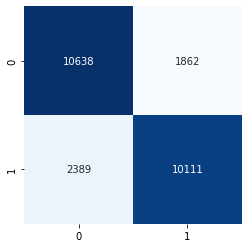

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [55]:
X_train[0]

array([0., 4., 0., ..., 0., 0., 0.])

In [20]:
words

{'movi': 50021,
 'film': 46628,
 'one': 26816,
 'like': 22248,
 'time': 15226,
 'good': 14867,
 'make': 14530,
 'get': 14041,
 'see': 13881,
 'charact': 13873,
 'watch': 13685,
 'would': 13387,
 'even': 12867,
 'stori': 12732,
 'realli': 11702,
 'scene': 10306,
 'well': 9873,
 'look': 9720,
 'show': 9676,
 'bad': 9656,
 'much': 9612,
 'could': 9377,
 'end': 9279,
 'peopl': 9272,
 'great': 9191,
 'also': 9099,
 'go': 9056,
 'first': 8974,
 'think': 8849,
 'love': 8770,
 'play': 8584,
 'way': 8518,
 'act': 8488,
 'thing': 8089,
 'made': 8013,
 'seem': 7552,
 'know': 7422,
 'say': 7421,
 'work': 6772,
 'mani': 6667,
 'two': 6654,
 'plot': 6640,
 'come': 6636,
 'actor': 6626,
 'want': 6609,
 'seen': 6567,
 'take': 6555,
 'never': 6436,
 'littl': 6387,
 'year': 6329,
 'tri': 6310,
 'best': 6292,
 'life': 6112,
 'ever': 5851,
 'give': 5778,
 'man': 5652,
 'still': 5626,
 'better': 5608,
 'find': 5427,
 'perform': 5399,
 'part': 5246,
 'feel': 5173,
 'use': 5057,
 'actual': 5054,
 'someth': 4

In [ ]:
X_train_text[0]

In [33]:
dataset['train']['text']

['i rent i am from my video store becaus of all the controversi that surround it when it was first releas in i also heard that at first it was seiz by custom if it ever tri to enter this countri therefor be a fan of film consid controversi i realli had to see this for br br the plot is center around a young swedish drama student name lena who want to learn everyth she can about life in particular she want to focus her attent to make some sort of documentari on what the averag swede thought about certain polit issu such as the vietnam war and race issu in the unit state in between ask politician and ordinari denizen of stockholm about their opinion on polit she has sex with her drama teacher classmat and marri br br what kill me about i am is that 40 year ago this was consid pornograph realli the sex and nuditi scene are few and far between even then it not shot like some cheapli made porno while my countrymen mind find it shock in realiti sex and nuditi are a major stapl in swedish cin

In [60]:
le

{'movi': 0,
 'film': 1,
 'one': 2,
 'like': 3,
 'time': 4,
 'good': 5,
 'make': 6,
 'get': 7,
 'see': 8,
 'charact': 9,
 'watch': 10,
 'would': 11,
 'even': 12,
 'stori': 13,
 'realli': 14,
 'scene': 15,
 'well': 16,
 'look': 17,
 'show': 18,
 'bad': 19,
 'much': 20,
 'could': 21,
 'end': 22,
 'peopl': 23,
 'great': 24,
 'also': 25,
 'go': 26,
 'first': 27,
 'think': 28,
 'love': 29,
 'play': 30,
 'way': 31,
 'act': 32,
 'thing': 33,
 'made': 34,
 'seem': 35,
 'know': 36,
 'say': 37,
 'work': 38,
 'mani': 39,
 'two': 40,
 'plot': 41,
 'come': 42,
 'actor': 43,
 'want': 44,
 'seen': 45,
 'take': 46,
 'never': 47,
 'littl': 48,
 'year': 49,
 'tri': 50,
 'best': 51,
 'life': 52,
 'ever': 53,
 'give': 54,
 'man': 55,
 'still': 56,
 'better': 57,
 'find': 58,
 'perform': 59,
 'part': 60,
 'feel': 61,
 'use': 62,
 'actual': 63,
 'someth': 64,
 'back': 65,
 'interest': 66,
 'lot': 67,
 'director': 68,
 'real': 69,
 'though': 70,
 'cast': 71,
 'anoth': 72,
 'enjoy': 73,
 'live': 74,
 'noth': 7